In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import math
import numpy as np
from scipy.stats import norm

In [3]:
from keras.layers import Input, Dense, Activation, Lambda, Embedding, Reshape, RepeatVector
from keras.layers import merge
from keras.models import Model
from keras import regularizers
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
from keras import objectives

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled)


### References :
##### VAE with GMM : https://arxiv.org/pdf/1611.05148.pdf
##### KL for GMM : https://github.com/RuiShu/vae-experiments/blob/master/modality/misc/gmm_kld_derivation.pdf
##### GMM VAE blog post : http://ruishu.io/2016/12/25/gmvae/
##### DEC model : https://ai2-website.s3.amazonaws.com/publications/unsupervised-deep-embedding.pdf
##### Categorical VAE parameterization : http://blog.evjang.com/2016/11/tutorial-categorical-variational.html
##### Auto-Encoding Variational Bayes : https://arxiv.org/abs/1312.6114
##### Tutorial from Oliver Durr : https://home.zhaw.ch/~dueo/bbs/files/vae.pdf
##### Building autoencoders in keras : https://blog.keras.io/building-autoencoders-in-keras.html

## KL between 2 normal distributions

* a) if N(0,1)^d if one of the 2 distributions

       KL = 0.5 SUM_OVER_DIMS[ -1 - log_var + square(mean) + var ]

* b) for 2 diagonal covariances matrices

       KL = 0.5 SUM_OVER_DIMS[ -1 + log(var2)-log(var1) + var1/var2 + (mean1-mean2)^2 / var2 ]
       
* c) see most general formula at :

       stats.stackexchange.com/questions/60680/kl-divergence-between-two-multivariate-gaussians/60699#60699

In [4]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

## Variational Auto-Encoder with Gaussian Mixture generator

In [52]:
batch_size = 32
original_dim = 784
latent_dim = 2

NM = 2 # number of mixture clusters, 10 should be best, but slower to test

intermediate_dim1 = 500
intermediate_dim2 = 500

nb_epoch = 25
epsilon_std = 1.0

#### Reparameterization trick

In [53]:
# Approximate Multinomial distrib. with a Gumbel-Softmax distrib.
# see documentation at :
# http://blog.evjang.com/2016/11/tutorial-categorical-variational.html
def sampling_categorical(c_logits):
    temperature = 0.1 # the lower it is the sharper the function is
    eps = 1e-20
    U = K.random_uniform(shape=(batch_size, NM), low=0, high=1)
    gumbel_noise = -K.log(-K.log(U + eps) + eps)
    # WARNING : dont return softmax as we apply it NEXT
    #return gumbel_noise
    return (c_logits + gumbel_noise) / temperature
    #return K.softmax((c_logits+gumbel_noise)/temperature)

def sampling_normal(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              std=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

#### Lambda functions

In [54]:
def log_pdf_normal(args):
    # WARNING : assumes covariance is diagonal
    # INFO : returns log of pdf for softmax function
    mu, log_var, z = args
    return -0.5 * ( K.sum(K.square(mu - z) / K.exp(log_var), axis=1)
                    + K.sum(log_var, axis=1)
                    + latent_dim * math.log(2*math.pi) )

def kl_normal(args):
    i_mean, i_log_var, z_mean, z_log_var = args
    return -0.5 * K.sum( 1 
                        - i_log_var + z_log_var
                        - K.exp(z_log_var)/K.exp(i_log_var)
                        - K.square(z_mean - i_mean) / K.exp(i_log_var) , axis=1)

In [55]:
x = Input(batch_shape=(batch_size, original_dim))
h1 = Dense(intermediate_dim1, activation='softplus')(x)
h2 = Dense(intermediate_dim2, activation='softplus')(h1)
z_mean = Dense(latent_dim, activation=None)(h2)
z_log_var = Dense(latent_dim, activation=None)(h2)

#ONEINT = Input(batch_shape=(batch_size, 1))

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling_normal, output_shape=(latent_dim,))([z_mean, z_log_var])

E_mean = Embedding(NM, latent_dim, init='zero', input_length=1) # WARNING : needs near-0 initialization
E_mean.trainable = False
E_log_var = Embedding(NM, latent_dim, init='zero', input_length=1) # WARNING : needs near-log(1) initialization
E_log_var.trainable = False

logpdfs = []
kl_losses = []
for i in range(NM):
    # Tensor with constant i value
    dummy_d = Dense(1, weights=[np.zeros((original_dim, 1)),i*np.ones((1,))], input_dim=original_dim)
    dummy_d.trainable = False
    ohe_i = dummy_d(x)
    # Apply tensor to Mean and Var embeddings
    i_mean = Reshape((latent_dim,))( E_mean(ohe_i) )
    i_log_var = Reshape((latent_dim,))( E_log_var(ohe_i) )
    # PDF
    logpdfs.append( Reshape((1,))( Lambda(log_pdf_normal, output_shape=(1,))([i_mean, i_log_var, z]) ) )
    # Compute KL-loss terms
    kl_losses.append( Reshape((1,))( Lambda(kl_normal, output_shape=(1,))([i_mean, i_log_var, z_mean, z_log_var]) ) )


#logpdfmat = Reshape((NM,1))( merge(logpdfs, mode='concat', concat_axis=1) ) # .summary to check axis
logpdfmat = merge(logpdfs, mode='concat', concat_axis=1) # .summary to check axis
c_logits = Activation('softmax')(logpdfmat)
# WARNING : need to compute c_logits from z
c_lambda = Lambda(sampling_categorical, output_shape=(NM,))(c_logits)
c = Activation('softmax')( c_lambda )

klmat = Reshape((NM,))( merge(kl_losses, mode='concat', concat_axis=1) )

# INFO : kl_loss needs to be = -log(SUM(prob_j * exp(-KL_j)))
p_j = 1./NM
emklmat = Lambda(lambda x : p_j * K.exp(-x), output_shape=(NM,))(klmat)
kl_loss = Lambda(lambda x : -K.log(x), output_shape=(1,))(merge([c, emklmat], mode='dot'))

##############################

#inputs = Input(shape=(nn_input_dim,))
#inputs = x
#outputs = Input(shape=(8,)) # in AE model output=input=x
#outputs = x

predictions = []
for i in range(NM):
    decoder_h1 = Dense(intermediate_dim1, activation='softplus')
    decoder_h2 = Dense(intermediate_dim2, activation='softplus')
    decoder_proba = Dense(original_dim, activation='sigmoid')
    h1_decoded = decoder_h1(z)
    h2_decoded = decoder_h2(h1_decoded)
    i_x_decoded_proba = decoder_proba(h2_decoded) # a Bernoulli dist. has a single prob. parameter
    predictions.append( i_x_decoded_proba )


x_decoded_proba = predictions[0]

'''
predmat = Reshape((NM,original_dim))( merge(predictions, mode='concat', concat_axis=1) ) #.summary to check axis

deltas = merge([RepeatVector(NM)(outputs), predmat], output_shape=(NM,original_dim), mode=lambda x: -(x[0] * K.log(x[1])))

deltasums = Lambda(lambda x: K.sum(x, axis=2), output_shape=lambda s: (s[0], s[1]))(deltas)# .summary to check axis

hinton_trick = True # see "Adaptive Mixtures of Local Experts"
if hinton_trick:
    Hinton1 = Lambda(lambda x: K.exp(-x), output_shape=lambda s: s)
    deltasums = Hinton1(deltasums)

# WARNING : gate is just the sampled c vector
gate = c

errors = merge([gate, deltasums], mode='dot')
##############################
'''

'\npredmat = Reshape((NM,original_dim))( merge(predictions, mode=\'concat\', concat_axis=1) ) #.summary to check axis\n\ndeltas = merge([RepeatVector(NM)(outputs), predmat], output_shape=(NM,original_dim), mode=lambda x: -(x[0] * K.log(x[1])))\n\ndeltasums = Lambda(lambda x: K.sum(x, axis=2), output_shape=lambda s: (s[0], s[1]))(deltas)# .summary to check axis\n\nhinton_trick = True # see "Adaptive Mixtures of Local Experts"\nif hinton_trick:\n    Hinton1 = Lambda(lambda x: K.exp(-x), output_shape=lambda s: s)\n    deltasums = Hinton1(deltasums)\n\n# WARNING : gate is just the sampled c vector\ngate = c\n\nerrors = merge([gate, deltasums], mode=\'dot\')\n##############################\n'

In [56]:
#type(z), type(logpdfmat), logpdfmat.shape[0], logpdfmat.shape[1]
print z.shape.eval({x:x_train[0:batch_size,:]})
#print z.size.eval({x:x_train[0:batch_size,:]})
print logpdfmat.shape.eval({x:x_train[0:batch_size,:]})
print logpdfmat.shape.eval({x:x_train[0:batch_size,:]})
#print dir(logpdfmat)
print z._keras_shape, c_logits._keras_shape, c_lambda._keras_shape, c._keras_shape
print c_lambda.shape.eval({x:x_train[0:batch_size,:]})
print c.shape.eval({x:x_train[0:batch_size,:]})
print kl_losses[0].shape.eval({x:x_train[0:batch_size,:]})
print klmat.shape.eval({x:x_train[0:batch_size,:]})
print emklmat.shape.eval({x:x_train[0:batch_size,:]})
print kl_loss.shape.eval({x:x_train[0:batch_size,:]})

[32  2]
[32  2]
[32  2]
(32, 2) (32, 2) (32, 2) (32, 2)
[32  2]
[32  2]
[32  1]
[32  2]
[32  2]
[32  1]


In [57]:
(objectives.binary_crossentropy(x, x_decoded_proba)).eval({x:x_train[0:batch_size,:]}).shape

(32,)

In [58]:
K.sum(kl_loss, axis=1).eval({x:x_train[0:batch_size,:]}).shape

(32,)

In [59]:
def vae_loss(x, x_decoded_proba):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_proba)
    #kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + K.sum(kl_loss, axis=1)

vae = Model(x, x_decoded_proba)
vae.compile(optimizer=Adam(1e-3), loss=vae_loss)

In [60]:
#mdl = Model([x, ONEINT], [logpdfs[0], logpdfs[1], logpdfs[2], logpdfs[3], logpdfs[4]])
#mdl = Model(x, logpdfmat)
#mdl = Model(x, z)
#mdl = Model(x, c_logits)
#mdl = Model(x, c_lambda)
#mdl = Model(x, c)
#mdl = Model(x, kl_losses[0])
mdl = Model(x, klmat)
#mdl = Model(x, emklmat)
#mdl = Model(x, kl_loss)
#mdl = Model(x, x_decoded_proba)
#mdl = Model([x, ONEINT], predmat)
#mdl = Model([x, ONEINT], deltas)
#mdl = Model([x, ONEINT], deltasums)
#mdl.summary()

In [61]:
#onearr = np.ones((batch_size, 1)).astype(int)
print mdl.predict(x_train[0:batch_size,:]).shape
np.array(mdl.predict(x_train[0:batch_size,:]))[0:5,:]

(32, 2)


array([[ 1.00375164,  1.00375164],
       [ 1.03628695,  1.03628695],
       [ 0.78361797,  0.78361797],
       [ 0.94545174,  0.94545174],
       [ 0.84388471,  0.84388471]], dtype=float32)

In [62]:
print vae.predict(x_train[0:batch_size,:]).shape
np.array(vae.predict(x_train[0:batch_size,:]))[0:3,:]

(32, 784)


array([[ 0.78982514,  0.45326167,  0.58801591, ...,  0.10494002,
         0.43279046,  0.36926267],
       [ 0.7898854 ,  0.4531233 ,  0.58803403, ...,  0.10482869,
         0.43278378,  0.36941445],
       [ 0.7884838 ,  0.45837846,  0.58731318, ...,  0.10480341,
         0.43401539,  0.36608297]], dtype=float32)

In [63]:
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (32, 784)             0                                            
____________________________________________________________________________________________________
dense_25 (Dense)                 (32, 500)             392500      input_8[0][0]                    
____________________________________________________________________________________________________
dense_26 (Dense)                 (32, 500)             250500      dense_25[0][0]                   
____________________________________________________________________________________________________
dense_27 (Dense)                 (32, 2)               1002        dense_26[0][0]                   
___________________________________________________________________________________________

In [76]:
vae.layers[-3]

In [64]:
#vae.optimizer.lr = 1e-3

In [70]:
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=1, # may have to increase this value
        batch_size=batch_size)
        #validation_data=(x_test, x_test))

Epoch 1/1
60000/60000 [==============================] - 25s - loss: 151.2186    


In [77]:
# build a model to project inputs on the latent space
encoder_mean = Model(x, z_mean)
#encoder_stdev = Model(x, K.exp(z_log_var / 2))

#encoder = Model(x, z)

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h1_decoded = vae.layers[-3](decoder_input)
_h2_decoded = vae.layers[-2](_h1_decoded)
_x_decoded_proba = vae.layers[-1](_h2_decoded)
generator = Model(decoder_input, _x_decoded_proba)

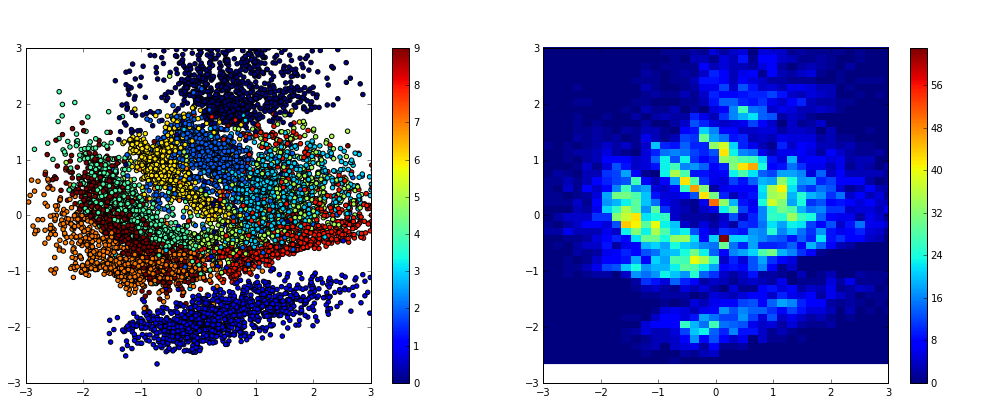

In [72]:
# display a 2D plot of the digit classes in a 2D projection of the latent space
x_test_encoded = encoder_mean.predict(x_test, batch_size=batch_size)

plt.figure(figsize=(17,6))
plt.subplot(1,2,1)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap=plt.cm.jet)
plt.colorbar()
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.subplot(1,2,2)
plt.hist2d(x_test_encoded[:,0], x_test_encoded[:,1], (50, 50), cmap=plt.cm.jet)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.colorbar()

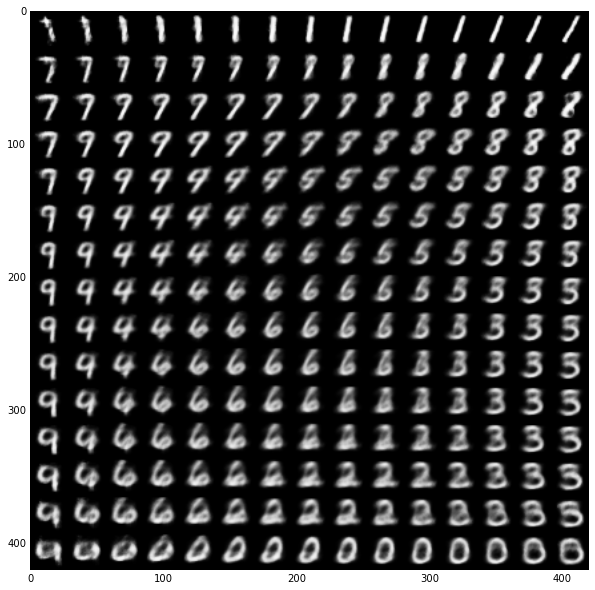

In [78]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()